In [1]:
import gymnasium as gym
import torch
import torch.nn as nn


In [2]:
env = gym.make('CartPole-v1')

In [3]:
class PolicyNetwork():
    def __init__(self,n_state,n_action,n_hidden=50,lr=0.001):
        '''
        forward prop
        '''
        self.model = nn.Sequential(
        nn.Linear(n_state,n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden,n_action),
        nn.Softmax(),
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr)
        
    def predict(self,s):
        '''
        Compute the action probabilities of state s using
     the learning model
        @param s: input state
        @return: predicted policy
        '''
        return self.model(torch.tensor(s))
    
    def update(self, returns, log_probs):
        policy_gradient = []
        for log_prob, Gt in zip(log_probs,returns):
            policy_gradient.append(-log_prob*Gt)
        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def get_action(self, s):
        '''
        @param s: input state
        @return: the selected action and log probability
        '''
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action,log_prob
        

# The REINFORCE Algorithm

In [4]:
def reinforce(env,estimator,n_episode,gamma=1.0):
    """
    REINFORCE algorithm
    @param env: Gym environment
    @param estimator: policy network
    @param n_episode: number of episodes
    @param gamma: the discount factor
    """
    for episode in range(n_episode):
        log_probs = []
        rewards = []
        state, info = env.reset()
        while True:
            action,log_prob = estimator.get_action(state)
            next_state,reward,terminated,truncated,info = env.step(action)
            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            rewards.append(reward)
            if terminated or truncated:
                returns = []
                Gt = 0 
                pw = 0 # this is essentially the power
                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1
                    returns.append(Gt)
                returns = returns[::-1]
                returns = torch.tensor(returns)
                returns = (returns - returns.mean()) / (returns.std() + 1e-9) # some sort of standardisation
                estimator.update(returns, log_probs)
                print('Episode: {}, total reward: {}'.format(
                    episode, total_reward_episode[episode]))
                break
            state = next_state

            

In [5]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.001
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)


In [6]:
gamma = 0.93

In [7]:
n_episode = 600
total_reward_episode = [0] * n_episode
reinforce(env,policy_net,n_episode,gamma)

/home/prathith/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode: 0, total reward: 40.0
Episode: 1, total reward: 41.0
Episode: 2, total reward: 33.0
Episode: 3, total reward: 26.0
Episode: 4, total reward: 21.0
Episode: 5, total reward: 19.0
Episode: 6, total reward: 16.0
Episode: 7, total reward: 46.0
Episode: 8, total reward: 12.0
Episode: 9, total reward: 57.0
Episode: 10, total reward: 13.0
Episode: 11, total reward: 9.0
Episode: 12, total reward: 18.0
Episode: 13, total reward: 26.0
Episode: 14, total reward: 30.0
Episode: 15, total reward: 17.0
Episode: 16, total reward: 24.0
Episode: 17, total reward: 18.0
Episode: 18, total reward: 35.0
Episode: 19, total reward: 29.0
Episode: 20, total reward: 62.0
Episode: 21, total reward: 19.0
Episode: 22, total reward: 26.0
Episode: 23, total reward: 18.0
Episode: 24, total reward: 13.0
Episode: 25, total reward: 21.0
Episode: 26, total reward: 29.0
Episode: 27, total reward: 19.0
Episode: 28, total reward: 17.0
Episode: 29, total reward: 25.0
Episode: 30, total reward: 17.0
Episode: 31, total 

Episode: 251, total reward: 126.0
Episode: 252, total reward: 105.0
Episode: 253, total reward: 122.0
Episode: 254, total reward: 190.0
Episode: 255, total reward: 158.0
Episode: 256, total reward: 292.0
Episode: 257, total reward: 262.0
Episode: 258, total reward: 240.0
Episode: 259, total reward: 275.0
Episode: 260, total reward: 323.0
Episode: 261, total reward: 243.0
Episode: 262, total reward: 366.0
Episode: 263, total reward: 387.0
Episode: 264, total reward: 117.0
Episode: 265, total reward: 151.0
Episode: 266, total reward: 250.0
Episode: 267, total reward: 119.0
Episode: 268, total reward: 92.0
Episode: 269, total reward: 34.0
Episode: 270, total reward: 109.0
Episode: 271, total reward: 141.0
Episode: 272, total reward: 231.0
Episode: 273, total reward: 46.0
Episode: 274, total reward: 57.0
Episode: 275, total reward: 93.0
Episode: 276, total reward: 246.0
Episode: 277, total reward: 157.0
Episode: 278, total reward: 305.0
Episode: 279, total reward: 471.0
Episode: 280, total

Episode: 493, total reward: 153.0
Episode: 494, total reward: 310.0
Episode: 495, total reward: 126.0
Episode: 496, total reward: 193.0
Episode: 497, total reward: 147.0
Episode: 498, total reward: 160.0
Episode: 499, total reward: 132.0
Episode: 500, total reward: 126.0
Episode: 501, total reward: 143.0
Episode: 502, total reward: 145.0
Episode: 503, total reward: 160.0
Episode: 504, total reward: 133.0
Episode: 505, total reward: 166.0
Episode: 506, total reward: 180.0
Episode: 507, total reward: 236.0
Episode: 508, total reward: 157.0
Episode: 509, total reward: 236.0
Episode: 510, total reward: 209.0
Episode: 511, total reward: 174.0
Episode: 512, total reward: 271.0
Episode: 513, total reward: 144.0
Episode: 514, total reward: 209.0
Episode: 515, total reward: 399.0
Episode: 516, total reward: 129.0
Episode: 517, total reward: 277.0
Episode: 518, total reward: 274.0
Episode: 519, total reward: 180.0
Episode: 520, total reward: 177.0
Episode: 521, total reward: 228.0
Episode: 522, 

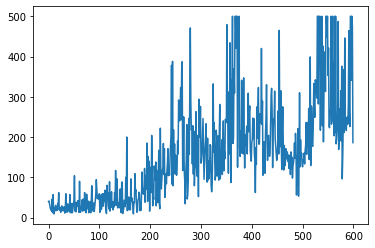

In [8]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)


In [9]:
import numpy as np
np.average(total_reward_episode)

157.62

# Saving and Using the Model
The following code should save the rl model in the given path. 

In [10]:
torch.save(policy_net.model.state_dict(),'saved_rl_model.pth')

In [11]:
# Using the model. 
loaded_estimator = PolicyNetwork(n_state, n_action, n_hidden, lr)

In [12]:
loaded_estimator.model.load_state_dict(torch.load('saved_rl_model.pth'))

<All keys matched successfully>

In [15]:
def evaluate_model(estimator, env, num_episodes):
    total_reward_episode = [0] * num_episodes
    for episode in range(num_episodes):
        rewards = []
        state, info = env.reset()
        while True:
            action,log_prob = estimator.get_action(state)
            next_state,reward,terminated,truncated,info = env.step(action)
            total_reward_episode[episode] += reward
            rewards.append(reward)
            if terminated or truncated:
                break
            state = next_state
    return total_reward_episode,np.mean(total_reward_episode),np.std(total_reward_episode)
                

In [16]:
evaluate_model(estimator=loaded_estimator, env=env,num_episodes=100)

/home/prathith/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


([41.0,
  17.0,
  18.0,
  23.0,
  10.0,
  12.0,
  10.0,
  51.0,
  17.0,
  11.0,
  23.0,
  28.0,
  17.0,
  23.0,
  11.0,
  12.0,
  18.0,
  15.0,
  16.0,
  25.0,
  23.0,
  30.0,
  33.0,
  12.0,
  12.0,
  18.0,
  25.0,
  26.0,
  9.0,
  15.0,
  10.0,
  10.0,
  26.0,
  10.0,
  9.0,
  28.0,
  14.0,
  26.0,
  13.0,
  14.0,
  33.0,
  16.0,
  38.0,
  21.0,
  33.0,
  20.0,
  14.0,
  25.0,
  18.0,
  13.0,
  11.0,
  26.0,
  12.0,
  14.0,
  9.0,
  16.0,
  15.0,
  18.0,
  27.0,
  21.0,
  32.0,
  61.0,
  25.0,
  18.0,
  27.0,
  26.0,
  11.0,
  21.0,
  18.0,
  17.0,
  20.0,
  10.0,
  12.0,
  27.0,
  17.0,
  10.0,
  43.0,
  17.0,
  14.0,
  12.0,
  15.0,
  18.0,
  16.0,
  15.0,
  14.0,
  13.0,
  10.0,
  11.0,
  16.0,
  15.0,
  17.0,
  11.0,
  29.0,
  19.0,
  11.0,
  20.0,
  16.0,
  20.0,
  12.0,
  15.0],
 19.12,
 9.086561505872284)